In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import sqlite3
import nltk

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re # Tutorial about Python regular expression: http://pymotw.com/2/re/

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


## Loading data 

In [2]:
con = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedtext,cleanedsummary
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


In [5]:
print(data.shape) # the no. of rows and columums of dataset
print(data['Score'].value_counts()) # the number of positive and negative dataset


(364171, 13)
1    307061
0     57110
Name: Score, dtype: int64


In [9]:
# randomly sample positive and negative reviews
# And take the 50k sample each of positive and negative review resp randomly
positive_data = data[data['Score'] == 1].sample(n = 50000)
negative_data = data[data['Score'] == 0].sample(n = 50000)
final_data = pd.concat([positive_data, negative_data])
final_data.shape

(100000, 13)

In [11]:
# sort the data based on time
final_data['Time'] = pd.to_datetime(final_data['Time'], unit='s')
final_data = final_data.sort_values(by = 'Time')
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedtext,cleanedsummary
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining hesita...,warning clamshell edition edited tv version
325,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,getting crazy looking beatlejuice french versi...,research beatlejuice video french version
837,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,2000-08-09,Very easy to use,This are so much easier to use than the Wilson...,much easier use wilson paste colors colors vib...,easy use
296,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,2000-10-03,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuice awe inspiring wonderfully amusing ...,fabulous comedic fanasy directed master
425,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,2001-06-11,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton brings distinguishing character...,casper ghost


# spliting the data

In [25]:
X = final_data['cleanedtext']
y = final_data['Score']
print('The shape of X : ', X.shape)
print('The shape of y : ', y.shape)


# Spliting the data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

The shape of X :  (100000,)
The shape of y :  (100000,)


In [26]:
print('the shape of X_train :',X_train.shape)
print('the shape of y_train ', y_train.shape)
print('the shape of X_test ',X_test.shape)
print('the shpa fo y_test ',y_test.shape)

the shape of X_train : (70000,)
the shape of y_train  (70000,)
the shape of X_test  (30000,)
the shpa fo y_test  (30000,)


### Naive Bayes using Bag of word

In [27]:
# Train vectorize
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train


<70000x51633 sparse matrix of type '<class 'numpy.int64'>'
	with 2325238 stored elements in Compressed Sparse Row format>

In [28]:
# Test vectorize
X_test = bow.transform(X_test)
X_test

<30000x51633 sparse matrix of type '<class 'numpy.int64'>'
	with 992500 stored elements in Compressed Sparse Row format>

In [29]:
print(X_train.shape)
print(X_test.shape)

(70000, 51633)
(30000, 51633)


In [30]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 1)

# fitting the model
clf.fit(X_train, y_train)



MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [31]:

# predict the response
pred = clf.predict(X_test)

In [39]:
# To get all the features name 
bow_features = bow.get_feature_names()


In [33]:
feat_count = clf.feature_count_
feat_count.shape

(2, 51633)

In [34]:
feat_count

array([[8., 1., 2., ..., 0., 0., 0.],
       [6., 2., 0., ..., 2., 1., 1.]])

In [51]:
# print the class count of each review in positive and negative class
print(clf.class_count_)
print()
print(clf.classes_)

[34996. 35004.]

[0 1]


In [37]:
log_prob = clf.feature_log_prob_
print(log_prob.shape)
log_prob

(2, 51633)


array([[-12.01453206, -13.51860945, -13.11314435, ..., -14.21175663,
        -14.21175663, -14.21175663],
       [-12.18638875, -13.03368661, -14.1322989 , ..., -13.03368661,
        -13.43915172, -13.43915172]])

In [40]:
feature_prob = pd.DataFrame(log_prob, columns=bow_features)
feature_prob_trans = feature_prob.T
feature_prob_trans.shape

(51633, 2)

In [45]:
# To show top 10 feature from both class
# Feature importance
print("Top 10 negative feature:- \n",feature_prob_trans[0].sort_values(ascending = False)[:10])
print()
print()
print("Top 10 positive feature:- \n",feature_prob_trans[1].sort_values(ascending = False)[:10])

Top 10 negative feature:- 
 like      -4.379067
product   -4.643532
taste     -4.670603
would     -4.799047
one       -4.856364
good      -5.090466
coffee    -5.144479
flavor    -5.153053
get       -5.394163
even      -5.400850
Name: 0, dtype: float64


Top 10 positive feature:- 
 like      -4.568840
good      -4.683335
great     -4.753736
one       -4.895706
taste     -4.968736
coffee    -5.059039
love      -5.081658
product   -5.082245
flavor    -5.086008
tea       -5.091206
Name: 1, dtype: float64


### Naive baiye using optimised alpha

In [46]:
# Find the optimal alpha

from sklearn.model_selection import cross_val_score

def naive_baiyes(X_train, y_train):
    alpha_values = np.arange(1, 100, 0.5)
    
    # empty list that will hold CV scores
    cv_scores = []
    
    # perform 10-fold cross-validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    MSE = [1-x for x in cv_scores]
    best_alpha = alpha_values[MSE.index(min(MSE))]
    return best_alpha, MSE

The best alpha : 10.0


Text(0.5, 1.0, 'Misclassification Error vs alpha')

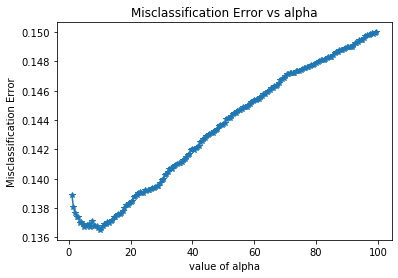

In [50]:
# best_alpha, MSE = naive_baiyes(X_train, y_train)
alpha_values = np.arange(1, 100, 0.5)
print("The best alpha :", best_alpha)
# plot the graph b/w misclassification and alpha_value
plt.plot(alpha_values, MSE, marker = '*')
plt.xlabel("value of alpha")
plt.ylabel("Misclassification Error")
plt.title("Misclassification Error vs alpha")

In [53]:
best_clf = MultinomialNB(alpha = best_alpha)

# fitting the model
best_clf.fit(X_train, y_train)



MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)

In [54]:
# predict the response
best_pred = best_clf.predict(X_test)

In [58]:
# To count feature for each class while fitting the model
best_feat_count = best_clf.feature_count_
print(best_feat_count.shape)
best_feat_count

(2, 51633)


array([[8., 1., 2., ..., 0., 0., 0.],
       [6., 2., 0., ..., 2., 1., 1.]])

In [56]:
log_prob = best_clf.feature_log_prob_
print(log_prob.shape)
log_prob

(2, 51633)


array([[-11.59344601, -12.08592249, -11.99891112, ..., -12.18123267,
        -12.18123267, -12.18123267],
       [-11.65127826, -11.93896034, -12.12128189, ..., -11.93896034,
        -12.02597171, -12.02597171]])

In [59]:
feature_prob = pd.DataFrame(log_prob, columns=bow_features)
feature_prob_trans = feature_prob.T
feature_prob_trans.shape

(51633, 2)

In [60]:
# To show top 10 feature from both class
# Feature importance
print("Top 10 negative feature:- \n",feature_prob_trans[0].sort_values(ascending = False)[:10])
print()
print()
print("Top 10 positive feature:- \n",feature_prob_trans[1].sort_values(ascending = False)[:10])

Top 10 negative feature:- 
 like      -4.650645
product   -4.914964
taste     -4.942018
would     -5.070373
one       -5.127647
good      -5.361544
coffee    -5.415502
flavor    -5.424068
get       -5.664892
even      -5.671570
Name: 0, dtype: float64


Top 10 positive feature:- 
 like      -4.859776
good      -4.974195
great     -5.044544
one       -5.186398
taste     -5.259361
coffee    -5.349575
love      -5.372171
product   -5.372757
flavor    -5.376516
tea       -5.381709
Name: 1, dtype: float64


In [65]:
# Accuracy on train data
train_acc_bow = best_clf.score(X_train, y_train)
print("Accuracy with alpha = 10:- ",train_acc_bow)
accuracy_alpha_1 = clf.score(X_train, y_train)
print("Accuracy with alpha = 1:- ", accuracy_alpha_1)

Accuracy with alpha = 10:-  0.8785
Accuracy with alpha = 1:-  0.8919571428571429


In [66]:
# Error on train data
train_err_bow = 1-train_acc_bow
error_alpha_1 = 1-accuracy_alpha_1
print("Error with alpha=1 :- ",error_alpha_1 )
print("Error with alpha=10 :- ",train_err_bow )

Error with alpha=1 :-  0.10804285714285711
Error with alpha=10 :-  0.12150000000000005


In [69]:
# Evaluate accuracy on test data
from sklearn.metrics import accuracy_score
test_acc_bow = accuracy_score(y_test, pred)
print("Accuracy of NBclassifier for alpha={} is {} ".format(best_alpha, test_acc_bow))

Accuracy of NBclassifier for alpha=10.0 is 0.8648666666666667 


In [70]:
confusion_mat = confusion_matrix(y_test, pred)
confusion_mat


array([[12700,  2304],
       [ 1750, 13246]], dtype=int64)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86     15004
           1       0.85      0.88      0.87     14996

    accuracy                           0.86     30000
   macro avg       0.87      0.86      0.86     30000
weighted avg       0.87      0.86      0.86     30000



## Naive Bayes using TF-IDF

In [80]:
# spliting the data into train and test
X = final_data['cleanedtext']
y = final_data['Score']
print('The shape of X : ', X.shape)
print('The shape of y : ', y.shape)




from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

The shape of X :  (100000,)
The shape of y :  (100000,)


In [81]:
print('the shape of X_train :',X_train.shape)
print('the shape of y_train ', y_train.shape)
print('the shape of X_test ',X_test.shape)
print('the shpa fo y_test ',y_test.shape)

the shape of X_train : (70000,)
the shape of y_train  (70000,)
the shape of X_test  (30000,)
the shpa fo y_test  (30000,)


In [82]:
# tf-idf
# tf-idf on train data
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vec.fit_transform(X_train)
X_train

<70000x1289594 sparse matrix of type '<class 'numpy.float64'>'
	with 4955625 stored elements in Compressed Sparse Row format>

In [76]:
feat_name = tf_idf_vec.get_feature_names()
# feat_name[:10]

['aa',
 'aa batteries',
 'aa best',
 'aa dark',
 'aa days',
 'aa extra',
 'aa group',
 'aa known',
 'aa offering',
 'aa quality']

In [83]:
# Apply tf-idf to test data to vectorise it
X_test = tf_idf_vec.transform(X_test)
X_test

<30000x1289594 sparse matrix of type '<class 'numpy.float64'>'
	with 1721991 stored elements in Compressed Sparse Row format>

The best alpha : 1.0


Text(0.5, 1.0, 'Misclassification Error vs alpha')

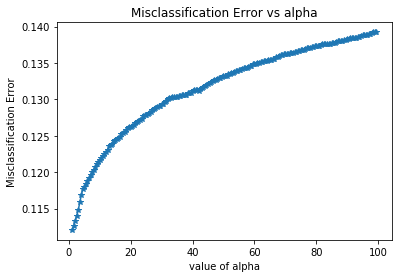

In [84]:
# Choose best alpha


# best_alpha_tfidf, MSE_tfidf = naive_baiyes(X_train, y_train)

alpha_value = np.arange(1, 100, 0.5)
print("The best alpha :", best_alpha_tfidf)
# plot the graph b/w misclassification and alpha_value
plt.plot(alpha_values, MSE_tfidf, marker = '*')
plt.xlabel("value of alpha")
plt.ylabel("Misclassification Error")
plt.title("Misclassification Error vs alpha")

In [86]:
clf = MultinomialNB(alpha = best_alpha_tfidf)

# fit the model 
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [87]:
# predict the value of X_test
pred = clf.predict(X_test)

In [90]:
clf.classes_

array([0, 1], dtype=int64)

In [88]:
feat_log_prob = clf.feature_log_prob_
print(feat_log_prob.shape)
feat_log_prob

(2, 1289594)


array([[-13.49881402, -14.14673573, -14.25318071, ..., -14.25318071,
        -14.25318071, -14.25318071],
       [-13.58398242, -14.24697806, -13.94552048, ..., -14.11112767,
        -14.02837827, -14.02837827]])

In [89]:

feat_prob = pd.DataFrame(feat_log_prob, columns=feat_name)
feat_prob = feat_prob.T
feat_prob.shape

(1289594, 2)

In [92]:
# print the top 10 positive and negative word
print("Top 10 negative :-\n",feat_prob[0].sort_values(ascending=False)[:10])
print()
print("Top 10 positive :-\n",feat_prob[1].sort_values(ascending=False)[:10])


Top 10 negative :-
 like      -7.968088
taste     -8.086648
product   -8.091987
would     -8.236145
coffee    -8.312742
one       -8.374128
flavor    -8.482892
good      -8.549781
tea       -8.613534
buy       -8.646743
Name: 0, dtype: float64

Top 10 positive :-
 great     -7.957248
good      -8.092442
love      -8.223722
coffee    -8.224002
tea       -8.229655
like      -8.236271
flavor    -8.456928
one       -8.460765
taste     -8.465049
product   -8.468108
Name: 1, dtype: float64


In [98]:
# Accuracy on train data
train_acc_tfidf = clf.score(X_train, y_train)
print("Accuracy on train data :- ", train_acc_tfidf*100)

# Error on train data
train_err_tfidf = 1 - train_acc_tfidf
print("Error on train data:- ", train_err_tfidf*100)


Accuracy on train data :-  97.39999999999999
Error on train data:-  2.6000000000000023


In [97]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(pred, y_test)
print("Accuracy on test data:- ", test_acc_tfidf*100)

Accuracy on test data:-  88.92333333333333


In [99]:
# confusion matrix
confusion_mat = confusion_matrix(y_test, pred)
confusion_mat

array([[13295,  1709],
       [ 1614, 13382]], dtype=int64)

In [101]:
# classification report 
# precision recall f1-score
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     15004
           1       0.89      0.89      0.89     14996

    accuracy                           0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000



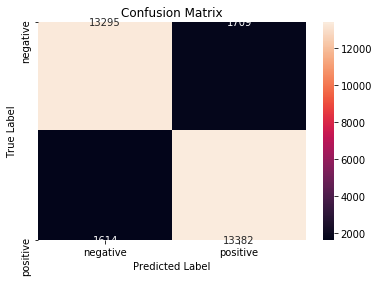

In [105]:
class_label = ["negative", "positive"]
conf_mat = pd.DataFrame(confusion_mat, index=class_label, columns=class_label)
sns.heatmap(conf_mat, annot= True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

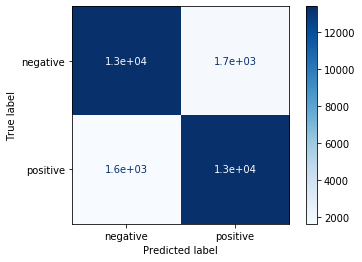

In [109]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_label,
                                 cmap=plt.cm.Blues
                                 )

### Bi-grams and n-Grams

In [36]:
#bi-grams, tri-gram and n-gram

# removing stopwords like 'not' should be avoided before building n-gram

count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram = count_vect.fit_transform(preprocessed_reviews)

print(final_bigram.get_shape())
print(count_vect.get_feature_names()[:10])

(4986, 139094)
['aa', 'aa sumatra', 'aahhhs', 'aahhhs get', 'aback', 'aback brand', 'abandon', 'abates', 'abates steeping', 'abbott']


### TF-IDF

In [46]:
# term frequency : 
# inverse document frequency

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)

print(final_tf_idf.get_shape())
features =  tf_idf_vect.get_feature_names()
print(features[:10])

(4986, 139094)
['aa', 'aa sumatra', 'aahhhs', 'aahhhs get', 'aback', 'aback brand', 'abandon', 'abates', 'abates steeping', 'abbott']


In [47]:
# convert a row in sparsematrix to numpy array
sparse = final_tf_idf[2,:].toarray()[0]
print(sparse)
print(len(sparse))

[0. 0. 0. ... 0. 0. 0.]
139094


In [48]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(sparse, features, 25)

In [49]:
top_tfidf

,feature,tfidf
0,printed,0.223244
1,windows,0.198860
2,windows everywhere,0.130098
3,shop program,0.130098
4,product windows,0.130098
5,car windows,0.130098
6,designed signs,0.130098
7,windows printed,0.130098
8,printed reverse,0.130098
9,printed beautifully,0.130098


### Word2Vec

In [50]:
# Train your own Word2Vec model using your own text corpus
list_of_sentence = []
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())
len(list_of_sentence)

4986

In [52]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sentence, min_count=5, size=50, 
                                   workers=4)

In [60]:
words = list(w2v_model.wv.vocab)
print(len(words))
print(words[:50])

3836
['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made', 'two']


In [54]:
w2v_model.wv.most_similar('tasty')

[('snack', 0.9984371066093445),
 ('crisp', 0.9983736276626587),
 ('crispy', 0.9983733892440796),
 ('fried', 0.998332679271698),
 ('artificial', 0.9983131289482117),
 ('light', 0.9982814788818359),
 ('greasy', 0.9982805848121643),
 ('texture', 0.9982209801673889),
 ('crunch', 0.9982200264930725),
 ('love', 0.9982093572616577)]

In [55]:
w2v_model.wv.most_similar('like')

[('sweet', 0.9967730045318604),
 ('taste', 0.9951509833335876),
 ('tastes', 0.9922884702682495),
 ('flavor', 0.9918922185897827),
 ('strong', 0.9913098216056824),
 ('milk', 0.9854931831359863),
 ('bitter', 0.9852263331413269),
 ('add', 0.9842127561569214),
 ('chocolate', 0.9839362502098083),
 ('green', 0.9835146069526672)]

In [56]:
count_vect_feat = count_vect.get_feature_names()
count_vect_feat.index('like')

68140

In [58]:
count_vect_feat[68140]

'like'

### Avg W2V, TFIDF-W2V

In [63]:
sentence_vec = []
for sentence in preprocessed_reviews:
    count_word = 0
    sent_vector = np.zeros(50)
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            sent_vector += vec
            count_word += 1
        except:
            pass
    sent_vector /= count_word
    sentence_vec.append(sent_vector)
print(len(sentence_vec))
print(len(sentence_vec[0]))

4986
50
